In [12]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from umap import UMAP
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
import scanpy as sc
from tqdm import tqdm

In [2]:
input_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Data_v3/'
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Scripts_software/Cuervo_lab/activation_model.xlsx' 
output_dir = r'./Sum_figs/'

# CMA aging Atlas Summary Figures
In this notebook we will perform summary figures for CMA score and measurements done by IF analysis (CMA activity, % of lysosomes competents for CMA or number of L1 positive lysosomes). The data for the CMA scores UMAPs was downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project, using the **All** files in its *Smart-seq2* version. 

## 1. UMAP Tabula muris + CMA Score

In [ ]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(tmfile)

In [4]:
# Subsetting only for tisscues of interest
adata = adata[adata.obs['tissue'].isin(['pancreas', 'heart', 'brain', 'liver', 'kidney'])]

In [5]:
# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

In [8]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

model_matrix

index           Cat Gene name Gene name Ms  Direction  Weight  \
0       0     Effectors     LAMP2        Lamp2          1       2   
1       1     Effectors     HSPA8        Hspa8          1       1   
2       2     Effectors  HSP90AA1     Hsp90aa1          1       1   
3       3     Effectors  HSP90AB1     Hsp90ab1          1       1   
4       4     Effectors    DNAJB1       Dnajb1          1       1   
5       5       LysoMod      GFAP         Gfap          1       1   
6       7       LysoMod    PHLPP1       Phlpp1          1       1   
7       9  ExtraLysoMod    NFATC1       Nfatc1          1       1   
8      10  ExtraLysoMod     NCOR1        Ncor1          1       1   
9      11  ExtraLysoMod    NFE2L2       Nfe2l2          1       1   
10     12  ExtraLysoMod    RAB11A       Rab11a          1       1   
11     13       LysoMod    RICTOR       Rictor         -1       1   
12     14       LysoMod      AKT1         Akt1         -1       1   
13     15       LysoMod      AKT2         Akt2         -1       1   
14     16       LysoMod      CTSA         Ctsa         -1       1   
15     17  ExtraLysoMod      RARA         Rara         -1       1   

   Uniprot_ID_H Uniprot_ID_Ms   Uniprot_Ms       Ensembl_ID  \
0        P13473        P17047  LAMP2_MOUSE  ENSG00000005893   
1        P11142        P63017  HSP7C_MOUSE  ENSG00000109971   
2        P07900        P07901  HS90A_MOUSE  ENSG00000080824   
3        P08238        P11499  HS90B_MOUSE  ENSG00000096384   
4        P25685        Q9QYJ3  DNJB1_MOUSE  ENSG00000132002   
5        P14136        P03995   GFAP_MOUSE  ENSG00000131095   
6        O60346        Q8CHE4  PHLP1_MOUSE  ENSG00000081913   
7        O95644        O88942  NFAC1_MOUSE  ENSG00000131196   
8        O75376        Q60974  NCOR1_MOUSE  ENSG00000141027   
9        Q16236        Q60795  NF2L2_MOUSE  ENSG00000116044   
10       P62491        P62492  RB11A_MOUSE  ENSG00000103769   
11       Q6R327        Q6QI06  RICTR_MOUSE  ENSG00000164327   
12       P31749        P31750   AKT1_MOUSE  ENSG00000142208   
13       P31749        P31750   AKT1_MOUSE  ENSG00000142208   
14       P10619        P16675   PPGB_MOUSE  ENSG00000064601   
15       P10276        P11416   RARA_MOUSE  ENSG00000131759   

            Ensembl_ms  
0   ENSMUSG00000016534  
1   ENSMUSG00000024359  
2   ENSMUSG00000021270  
3   ENSMUSG00000023944  
4   ENSMUSG00000005483  
5   ENSMUSG00000020932  
6   ENSMUSG00000044340  
7   ENSMUSG00000033016  
8   ENSMUSG00000018501  
9   ENSMUSG00000015839  
10  ENSMUSG00000004771  
11  ENSMUSG00000050310  
12  ENSMUSG00000001729  
13  ENSMUSG00000004056  
14  ENSMUSG00000017760  
15  ENSMUSG00000037992

In [9]:
# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd

# Generating a copy of adata.obs to work with
barcode = adata.obs

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   

barcode.head()

100%|██████████| 16/16 [00:00<00:00, 487.35it/s]
38411it [02:41, 237.86it/s]


FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ...               cell_type  \
index                                          ...                           
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  type B pancreatic cell   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...                  B cell   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  type B pancreatic cell   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...                  B cell   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  type B pancreatic cell   

                                            assay disease      organism  \
index                                                                     
A10_B000756_B007446_S10.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A10_B001361_B007505_S10.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A11_B000756_B007446_S11.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A11_B001361_B007505_S11.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   
A12_B000756_B007446_S12.mm10-plus-0-0  Smart-seq2  normal  Mus musculus   

                                          sex    tissue  \
index                                                     
A10_B000756_B007446_S10.mm10-plus-0-0    male  pancreas   
A10_B001361_B007505_S10.mm10-plus-0-0  female     heart   
A11_B000756_B007446_S11.mm10-plus-0-0    male  pancreas   
A11_B001361_B007505_S11.mm10-plus-0-0  female     heart   
A12_B000756_B007446_S12.mm10-plus-0-0    male  pancreas   

                                      self_reported_ethnicity  \
index                                                           
A10_B000756_B007446_S10.mm10-plus-0-0                      na   
A10_B001361_B007505_S10.mm10-plus-0-0                      na   
A11_B000756_B007446_S11.mm10-plus-0-0                      na   
A11_B001361_B007505_S11.mm10-plus-0-0                      na   
A12_B000756_B007446_S12.mm10-plus-0-0                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 mo

In [10]:
# Generating new ages
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = 'Young'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = 'Old'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = 'Old'
barcode.head()

100%|██████████| 38411/38411 [00:09<00:00, 3982.81it/s]


FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ...       assay disease  \
index                                          ...                       
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  Smart-seq2  normal   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...  Smart-seq2  normal   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  Smart-seq2  normal   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...  Smart-seq2  normal   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  Smart-seq2  normal   

                                           organism     sex    tissue  \
index                                                                   
A10_B000756_B007446_S10.mm10-plus-0-0  Mus musculus    male  pancreas   
A10_B001361_B007505_S10.mm10-plus-0-0  Mus musculus  female     heart   
A11_B000756_B007446_S11.mm10-plus-0-0  Mus musculus    male  pancreas   
A11_B001361_B007505_S11.mm10-plus-0-0  Mus musculus  female     heart   
A12_B000756_B007446_S12.mm10-plus-0-0  Mus musculus    male  pancreas   

                                      self_reported_ethnicity  \
index                                                           
A10_B000756_B007446_S10.mm10-plus-0-0                      na   
A10_B001361_B007505_S10.mm10-plus-0-0                      na   
A11_B000756_B007446_S11.mm10-plus-0-0                      na   
A11_B001361_B007505_S11.mm10-plus-0-0                      na   
A12_B000756_B007446_S12.mm10-plus-0-0                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 month-old stage         6Y}n#KG|Bw   

                                          score  new_age  
index                                                     
A10_B000756_B007446_S10.mm10-plus-0-0 -0.160629      Old  
A10_B001361_B007505_S10.mm10-plus-0-0  0.068699      Old  
A11_B000756_B007446_S11.mm10-plus-0-0  0.013144      Old  
A11_B001361_B007505_S11.mm10-plus-0-0  0.164582      Old  
A12_B000756_B007446_S12.mm10-plus-0-0  0.210844      Old  

[5 ro

In [11]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == 'Young']['score'])

for i in tqdm(barcode.index):
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

  0%|          | 0/38411 [00:00<?, ?it/s]

100%|██████████| 38411/38411 [00:07<00:00, 5165.14it/s]


FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ... disease      organism  \
index                                          ...                         
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  normal  Mus musculus   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...  normal  Mus musculus   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  normal  Mus musculus   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...  normal  Mus musculus   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  normal  Mus musculus   

                                          sex    tissue  \
index                                                     
A10_B000756_B007446_S10.mm10-plus-0-0    male  pancreas   
A10_B001361_B007505_S10.mm10-plus-0-0  female     heart   
A11_B000756_B007446_S11.mm10-plus-0-0    male  pancreas   
A11_B001361_B007505_S11.mm10-plus-0-0  female     heart   
A12_B000756_B007446_S12.mm10-plus-0-0    male  pancreas   

                                      self_reported_ethnicity  \
index                                                           
A10_B000756_B007446_S10.mm10-plus-0-0                      na   
A10_B001361_B007505_S10.mm10-plus-0-0                      na   
A11_B000756_B007446_S11.mm10-plus-0-0                      na   
A11_B001361_B007505_S11.mm10-plus-0-0                      na   
A12_B000756_B007446_S12.mm10-plus-0-0                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 month-old stage         6Y}n#KG|Bw   

                                          score new_age  net_score  
index                                                               
A10_B000756_B007446_S10.mm10-plus-0-0 -0.160629     Old  -0.217641  
A10_B001361_B007505_S10.mm10-plus-0-0  0.068699     Old   0.011687  
A11_B000756_B007446_S11.mm10-plus-0-0  0.013144     Old  -0.043868  
A11_B001361_B007505_S11.mm10-plus-0-0  0.164582     Old   0.107570  
A12_B000756_B007446_S12.mm10-plus-0-0  0.210844     Old   0.153832  

[5 rows x 35 column

In [12]:
# Calculation of net score to 3m by tissue
for maj_cell in tqdm(np.unique(barcode['tissue'])):
    
    µ = np.mean(barcode[barcode['tissue'] == maj_cell][barcode['new_age'] == 'Young']['score'])
    
    for cell_index in barcode[barcode['tissue'] == maj_cell].index:
    
        barcode.loc[cell_index, 'net_score_tissue'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:08<00:00,  1.70s/it]


FACS.selection  age         cell  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         Viable  18m  A10_B000756   
A10_B001361_B007505_S10.mm10-plus-0-0         Viable  18m  A10_B001361   
A11_B000756_B007446_S11.mm10-plus-0-0         Viable  18m  A11_B000756   
A11_B001361_B007505_S11.mm10-plus-0-0         Viable  18m  A11_B001361   
A12_B000756_B007446_S12.mm10-plus-0-0         Viable  18m  A12_B000756   

                                         free_annotation method donor_id  \
index                                                                      
A10_B000756_B007446_S10.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A10_B001361_B007505_S10.mm10-plus-0-0             B cell   facs  18_46_F   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreatic B cell   facs  18_45_M   
A11_B001361_B007505_S11.mm10-plus-0-0             B cell   facs  18_46_F   
A12_B000756_B007446_S12.mm10-plus-0-0                nan   facs  18_45_M   

                                       subtissue  n_genes     n_counts  \
index                                                                    
A10_B000756_B007446_S10.mm10-plus-0-0  Endocrine     3212  6891.192383   
A10_B001361_B007505_S10.mm10-plus-0-0         RV     1237  3588.732910   
A11_B000756_B007446_S11.mm10-plus-0-0  Endocrine     2544  6017.255371   
A11_B001361_B007505_S11.mm10-plus-0-0         RV     1257  3398.743164   
A12_B000756_B007446_S12.mm10-plus-0-0  Endocrine     3789  4215.626953   

                                      louvain  ...      organism     sex  \
index                                          ...                         
A10_B000756_B007446_S10.mm10-plus-0-0      31  ...  Mus musculus    male   
A10_B001361_B007505_S10.mm10-plus-0-0       1  ...  Mus musculus  female   
A11_B000756_B007446_S11.mm10-plus-0-0      31  ...  Mus musculus    male   
A11_B001361_B007505_S11.mm10-plus-0-0       1  ...  Mus musculus  female   
A12_B000756_B007446_S12.mm10-plus-0-0      31  ...  Mus musculus    male   

                                         tissue self_reported_ethnicity  \
index                                                                     
A10_B000756_B007446_S10.mm10-plus-0-0  pancreas                      na   
A10_B001361_B007505_S10.mm10-plus-0-0     heart                      na   
A11_B000756_B007446_S11.mm10-plus-0-0  pancreas                      na   
A11_B001361_B007505_S11.mm10-plus-0-0     heart                      na   
A12_B000756_B007446_S12.mm10-plus-0-0  pancreas                      na   

                                        development_stage observation_joinid  \
index                                                                          
A10_B000756_B007446_S10.mm10-plus-0-0  18 month-old stage         K4En@E!h(6   
A10_B001361_B007505_S10.mm10-plus-0-0  18 month-old stage         u9>4eO>X6P   
A11_B000756_B007446_S11.mm10-plus-0-0  18 month-old stage         l~84+$xuu{   
A11_B001361_B007505_S11.mm10-plus-0-0  18 month-old stage         l#3^K>nNvx   
A12_B000756_B007446_S12.mm10-plus-0-0  18 month-old stage         6Y}n#KG|Bw   

                                          score new_age net_score  \
index                                                               
A10_B000756_B007446_S10.mm10-plus-0-0 -0.160629     Old -0.217641   
A10_B001361_B007505_S10.mm10-plus-0-0  0.068699     Old  0.011687   
A11_B000756_B007446_S11.mm10-plus-0-0  0.013144     Old -0.043868   
A11_B001361_B007505_S11.mm10-plus-0-0  0.164582     Old  0.107570   
A12_B000756_B007446_S12.mm10-plus-0-0  0.210844     Old  0.153832   

                                       net_score_tissue  
index                                                    
A10_B000756_B007446_S10.mm10-plus-0-0         -0.229730  
A10_B001361_B007505_S10.mm10-plus-0-0          0.034573  
A11_B000756_B007446_S11.mm10-plus-0-0         -0.055958  
A11_B001361_B007505_S11.mm10-plus-0-0          0.130456  
A12_B000756_B00

In [13]:
adata.obs['tissue'] = adata.obs['tissue'].str.capitalize() #Capitalizing tissue names

#Giving order to tissues in adata.obs (aka barcode)
tejidos=['Brain', 'Heart', 'Kidney', 'Liver', 'Pancreas']

adata.obs['tissue']=pd.Categorical(
    values=adata.obs.tissue, categories=tejidos, ordered=True)

In [14]:
# Creating custom palette
pal = sns.color_palette('Dark2')
pal.append('#e41a1c')
pal


[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
 (0.4, 0.4, 0.4),
 '#e41a1c']

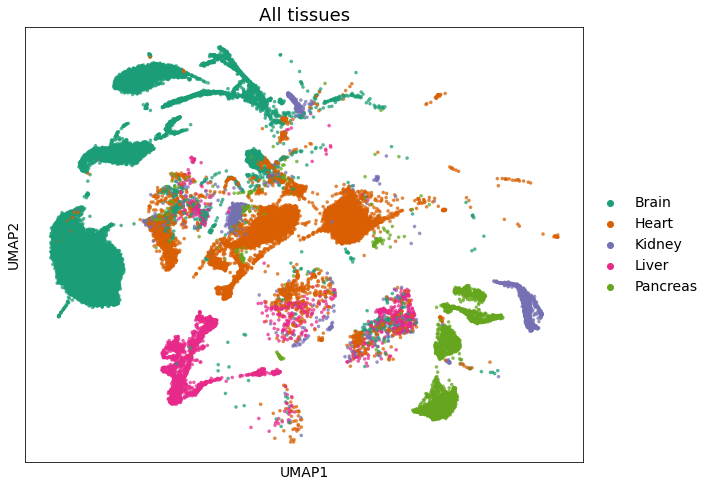

In [16]:
# UMAP for tissues
with plt.rc_context({"figure.figsize": (10, 8), "axes.labelsize":(14), "axes.titlesize":(18), "figure.facecolor":"white"}):
    sc.pl.umap(adata, color=['tissue'], palette=pal, legend_fontsize=14, title='All tissues', size=50, alpha=0.75, show=False)
    plt.savefig(outputdir+'/AT_umap.png',bbox_inches='tight', dpi=600)
    plt.show()

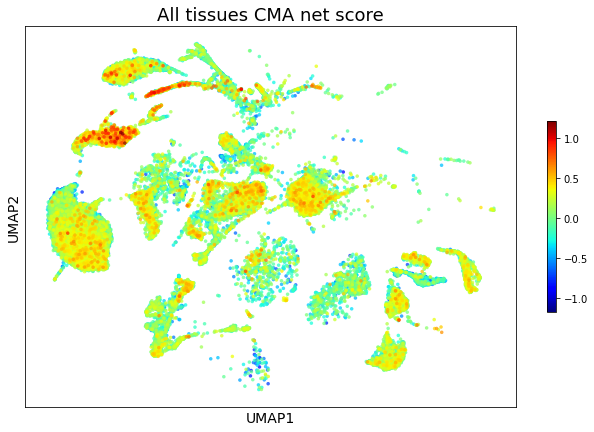

In [17]:
# UMAP for CMA net score per tissue
with plt.rc_context({"figure.figsize": (11, 7), "axes.labelsize":(14), "axes.titlesize":(18), "figure.facecolor":"white"}):
    sc.pl.umap(adata, color=['net_score_tissue'], cmap='jet',
               title='All tissues CMA net score', 
               legend_fontsize=14, size=50, alpha=0.75, show=False, colorbar_loc=None)
    
    fig = plt.gcf()
    norm = plt.Normalize(np.min(adata.obs['net_score_tissue']), 
                         np.max(adata.obs['net_score_tissue']))
    sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, shrink=.5)
    
# Plot the colorbar
    plt.savefig(outputdir+'/AT_umap_ptnscore.png',bbox_inches='tight', dpi=600)
    plt.show()

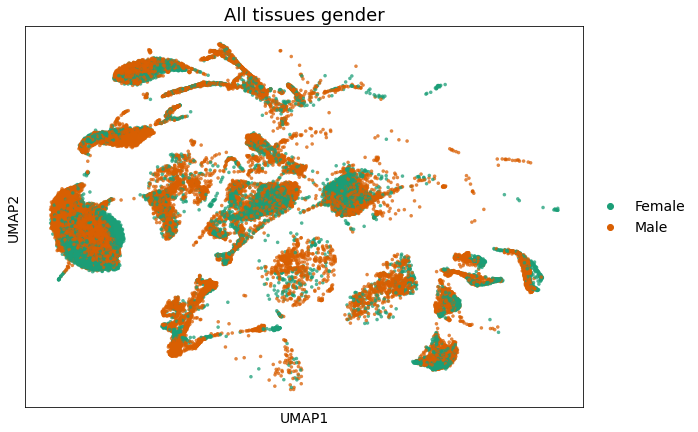

In [23]:
# UMAP for gender
adata.obs['sex'] = adata.obs['sex'].str.capitalize()
with plt.rc_context({"figure.figsize": (10, 7), "axes.labelsize":(14), "axes.titlesize":(18), "figure.facecolor":"white"}):
    sc.pl.umap(adata, color=['sex'], palette=pal, title= 'All tissues gender', size=50, alpha=0.75, legend_fontsize=14, show=False)
    plt.savefig(outputdir+'/AT_umap_sex.png',bbox_inches='tight', dpi=600)
    plt.show()

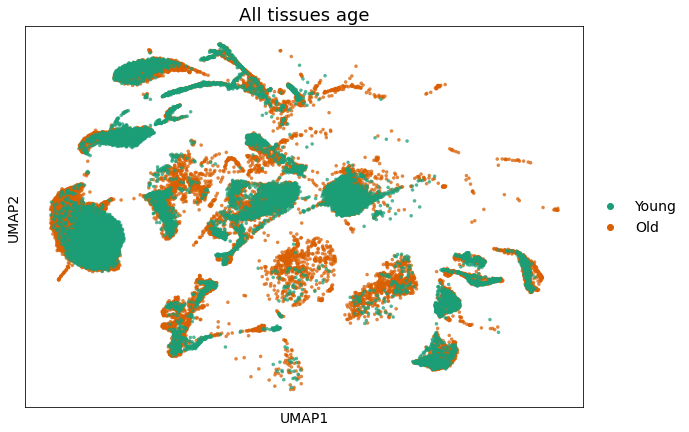

In [24]:
# UMAP for age
adata.obs['new_age']=pd.Categorical(values=adata.obs.new_age, categories=['Young', 'Old'], ordered=True)
with plt.rc_context({"figure.figsize": (10, 7), "axes.labelsize":(14), "axes.titlesize":(18), "figure.facecolor":"white"}):
    sc.pl.umap(adata, color=['new_age'], palette=pal, title= 'All tissues age', size=50, alpha=0.75, legend_fontsize=14, show=False)
    plt.savefig(outputdir+'/AT_umap_age.png',bbox_inches='tight', dpi=600)
    plt.show()

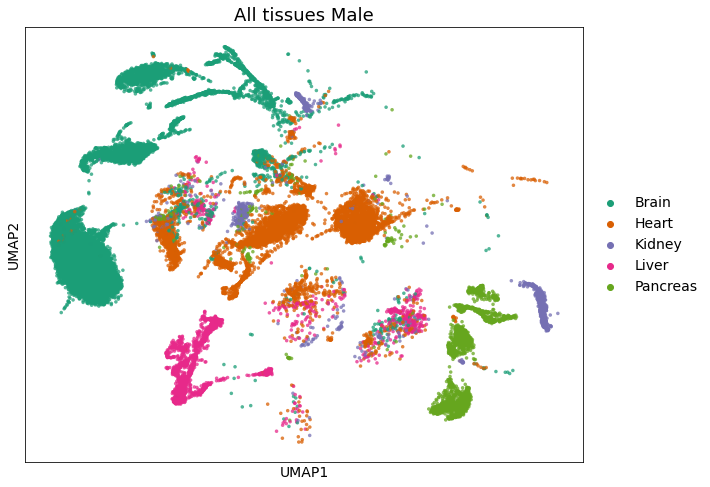

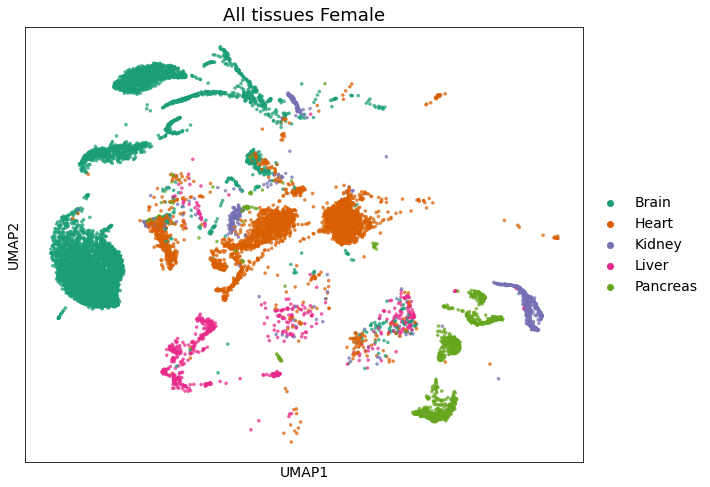

In [25]:
#UMAP for tissues by gender
for i in barcode.sex.unique():
    # UMAP for tissues
    with plt.rc_context({"figure.figsize": (10, 8), "axes.labelsize":(14), "axes.titlesize":(18), "figure.facecolor":"white"}):
        sc.pl.umap(adata[(adata.obs['sex']==i)], 
                   color=['tissue'], palette=pal, size=50, alpha=0.75, legend_fontsize=14, 
                   title='All tissues ' + i, show=False)
        if i == 'Female':
            plt.savefig(outputdir+'/AT_umap_'+'f.png',bbox_inches='tight', 
                        dpi=600)
        else:
            plt.savefig(outputdir+'/AT_umap_'+'m.png',bbox_inches='tight', 
                        dpi=600)
        plt.show()
    

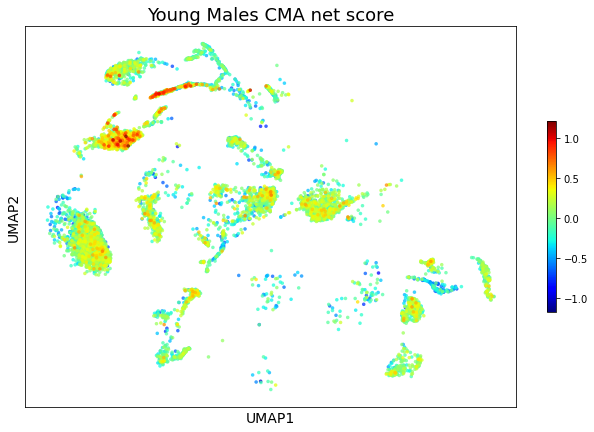

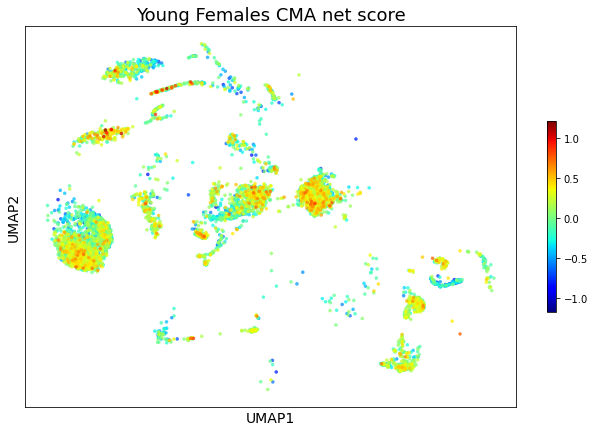

In [27]:
# UMAP for CMA net score per tissue by gender and age
for i in barcode.sex.unique():
    # UMAP for CMA net score per tissue
    with plt.rc_context({"figure.figsize": (11, 7), "axes.labelsize":(14), "axes.titlesize":(18), "figure.facecolor":"white"}):
        sc.pl.umap(adata[(adata.obs['sex']==i) & (adata.obs['new_age']=='Young')], 
                    color=['net_score_tissue'], cmap='jet', 
                    title='Young {}s CMA net score'.format(i), 
                    legend_fontsize=14, size=50, alpha=0.75, show=False,
                    colorbar_loc=None)
        fig = plt.gcf()
        norm = plt.Normalize(np.min(adata.obs['net_score_tissue']),
                                np.max(adata.obs['net_score_tissue']))
        sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
        sm.set_array([])
        fig.colorbar(sm, shrink=.5)
        
        if i == 'Female':
            plt.savefig(outputdir+'/AT_umap_'+'fyptnscore.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Male':
            plt.savefig(outputdir+'/AT_umap_'+'myptnscore.png',bbox_inches='tight', 
                        dpi=600)
        plt.show()
    

In [36]:
# Adjusting brain regions'name:
for j in barcode.index:    
    if barcode.loc[j, 'subtissue'] == 'Cortex ':        
        barcode.loc[j, 'subtissue'] = 'Cortex'

    elif barcode.loc[j, 'subtissue'] == 'Hippocampus ':                
        barcode.loc[j, 'subtissue'] = 'Hippocampus'
    
    elif barcode.loc[j, 'subtissue'] == 'Cerebellum ':                
        barcode.loc[j, 'subtissue'] = 'Cerebellum'
    
# Generating new cell types:
for j in barcode.index:    
    if barcode.loc[j, 'cell_type'] == 'neuron' and  barcode.loc[j, 'subtissue'] == 'Cortex':
        barcode.loc[j, 'new_cell'] = 'CX neuron'

    elif barcode.loc[j, 'cell_type'] == 'neuron' and  barcode.loc[j, 'subtissue'] == 'Hippocampus':
        barcode.loc[j, 'new_cell'] = 'HC neuron'

    elif barcode.loc[j, 'cell_type'] == 'neuron' and  barcode.loc[j, 'subtissue'] == 'Cerebellum':
        barcode.loc[j, 'new_cell'] = 'CB excitatory neuron'

    elif barcode.loc[j, 'cell_type'] == 'interneuron' and  barcode.loc[j, 'subtissue'] == 'Cerebellum':
        barcode.loc[j, 'new_cell'] = 'CB inhibitory neuron'

    elif barcode.loc[j, 'cell_type'] == 'astrocyte' and  barcode.loc[j, 'subtissue'] == 'Hippocampus':
        barcode.loc[j, 'new_cell'] = 'HC astrocyte'

    elif barcode.loc[j, 'cell_type'] == 'astrocyte' and  barcode.loc[j, 'subtissue'] == 'Cortex':
        barcode.loc[j, 'new_cell'] = 'CX astrocyte'
    
    elif barcode.loc[j, 'cell_type'] == 'type B pancreatic cell':
        barcode.loc[j, 'new_cell'] = 'pancreatic B cell'
    
    elif barcode.loc[j, 'cell_type'] == 'epithelial cell of proximal tubule':        
        barcode.loc[j, 'new_cell'] = 'tubules'
    
    elif barcode.loc[j, 'cell_type'] == 'mesangial cell':        
        barcode.loc[j, 'new_cell'] = 'glomeruli'
    
    elif barcode.loc[j, 'cell_type'] == 'kidney collecting duct epithelial cell' or barcode.loc[j, 'cell_type'] == 'kidney collecting duct principal cell':        
        barcode.loc[j, 'new_cell'] = 'collecting ducts'
    
    elif barcode.loc[j, 'cell_type'] == 'regular atrial cardiac myocyte' or barcode.loc[j, 'cell_type'] == 'regular ventricular cardiac myocyte':                
        barcode.loc[j, 'new_cell'] = 'cardiomyocyte'    
    
    else:                
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']

## 2. UMAP on Dendra IFs data + Lysosomal parameters (CMA activity, %L1 & L1+)

In [4]:
# Loading dataframe
df = pd.read_excel('./CMA_aging_Atlas_ifscdata.xlsx')
df.head()

ORGAN       REGION AREA CELL TYPE      SEX     AGE  CMA ACTIVITY (Den+L1+)  \
0  Brain  Hippocampus  CA1   Neurons  Female   Young              8771.396360   
1  Brain  Hippocampus  CA1   Neurons  Female   Young              9709.221754   
2  Brain  Hippocampus  CA1   Neurons  Female   Young             10273.510998   
3  Brain  Hippocampus  CA1   Neurons  Female   Young             14042.212294   
4  Brain  Hippocampus  CA1   Neurons  Female   Young              7309.496966   

     % of L1           L1+  
0  12.857143  68221.971685  
1  17.142857  56637.126899  
2  17.857143  57531.661591  
3  21.621622  64945.231861  
4   9.433962  77480.667842

In [5]:
# Correcting some misspelled errors
df['SEX'] = df['SEX'].replace('Female ', 'Female')
df['AGE'] = df['AGE'].replace('Young ', 'Young')
print(df.SEX.unique())
print(df.AGE.unique())

['Female' 'Male']
['Young' 'Old']


In [6]:
# Clarifying BAT from WAT while joining sWAT and vWAT
for index, rows in df.iterrows():
    if df.loc[index, 'REGION'] in ['vWAT', 'sWAT']:
        df.loc[index, 'ORGAN_2'] = 'WAT'
    
    elif df.loc[index, 'REGION'] == 'BAT':
        df.loc[index, 'ORGAN_2'] = 'BAT'
    
    else:
        df.loc[index, 'ORGAN_2'] = df.loc[index, 'ORGAN']

df = df[['ORGAN', 'ORGAN_2', 'REGION', 'AREA', 'CELL TYPE', 'SEX', 'AGE',
       'CMA ACTIVITY (Den+L1+)', '% of L1', 'L1+']]

print(df.ORGAN_2.unique())

df.head()

['Brain' 'Retina' 'Liver' 'BAT' 'WAT' 'Pancreas' 'Skeletal muscle'
 'Kidney' 'Heart']


ORGAN ORGAN_2       REGION AREA CELL TYPE     SEX    AGE  \
0  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
1  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
2  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
3  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
4  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   

   CMA ACTIVITY (Den+L1+)    % of L1           L1+  
0             8771.396360  12.857143  68221.971685  
1             9709.221754  17.142857  56637.126899  
2            10273.510998  17.857143  57531.661591  
3            14042.212294  21.621622  64945.231861  
4             7309.496966   9.433962  77480.667842

In [7]:
# Adding cell types markers adjusting just for CELL TYPE
df['NeuN'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Neurons' else 0)
df['GFAP'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Astrocytes' else 0)
df['Calbindin'] = df['AREA'].apply(lambda x: 1 if x == 'Inhibitory' else 0)
df['Recoverin'] = df['REGION'].apply(lambda x: 1 if x == 'Rods' else 0)
df['Arrestin'] = df['REGION'].apply(lambda x: 1 if x == 'Cones' else 0)
df['Hepato'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Hepatocytes' else 0)
df['Kupf'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Kupffer' else 0)
df['bat'] = df['AREA'].apply(lambda x: 1 if x == 'BAT' else 0)
df['vwat'] = df['AREA'].apply(lambda x: 1 if x == 'vWAT' else 0)
df['swat'] = df['AREA'].apply(lambda x: 1 if x == 'sWAT' else 0)
df['Acin'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Acinar cells' else 0)
df['Insulin'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'β-cells' else 0)
df['Glucagon'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'α- cells' else 0)
df['Musc'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Myofibers' else 0)
df['Glom'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Glomeruli' else 0)
df['Tub'] = df['AREA'].apply(lambda x: 1 if x == 'Tubules' else 0)
df['Aquaporin'] = df['AREA'].apply(lambda x: 1 if x == 'Collecting ducts' else 0)
df['Cor'] = df['CELL TYPE'].apply(lambda x: 1 if x == 'Cardiomyocytes' else 0)

df.head()              

ORGAN ORGAN_2       REGION AREA CELL TYPE     SEX    AGE  \
0  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
1  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
2  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
3  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
4  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   

   CMA ACTIVITY (Den+L1+)    % of L1           L1+  ...  vwat  swat  Acin  \
0             8771.396360  12.857143  68221.971685  ...     0     0     0   
1             9709.221754  17.142857  56637.126899  ...     0     0     0   
2            10273.510998  17.857143  57531.661591  ...     0     0     0   
3            14042.212294  21.621622  64945.231861  ...     0     0     0   
4             7309.496966   9.433962  77480.667842  ...     0     0     0   

   Insulin  Glucagon  Musc  Glom  Tub  Aquaporin  Cor  
0        0         0     0     0    0          0    0  
1        0         0     0     0    0          0    0  
2        0         0     0     0    0          0    0  
3        0         0     0     0    0          0    0  
4        0         0     0     0    0          0    0  

[5 rows x 28 columns]

In [8]:
# Scaling data, Z scores are calculated including the cell markers columns
scaled_data = StandardScaler().fit_transform(df[df.columns[7:]])
scaled_data

array([[-0.12053859, -0.29130604, -0.07690363, ..., -0.20529806,
        -0.1828551 , -0.29015032],
       [-0.07014794, -0.08208187, -0.20914069, ..., -0.20529806,
        -0.1828551 , -0.29015032],
       [-0.0398279 , -0.04721117, -0.19892988, ..., -0.20529806,
        -0.1828551 , -0.29015032],
       ...,
       [-0.59183782, -0.91897856, -0.61168104, ..., -0.20529806,
        -0.1828551 ,  3.44648944],
       [-0.59183782, -0.91897856, -0.44597771, ..., -0.20529806,
        -0.1828551 ,  3.44648944],
       [-0.59183782, -0.91897856, -0.45760334, ..., -0.20529806,
        -0.1828551 ,  3.44648944]])

In [9]:
# Adding Z scores for lysosomal parameters to df
scaled_df = pd.DataFrame(scaled_data)
scaled_df.rename(columns={0:'std_CMA_actv', 1:'std_%L1', 2:'std_L1+'}, inplace=True)
scaled_df = scaled_df[['std_CMA_actv', 'std_%L1', 'std_L1+']]
scaled_df.head()

std_CMA_actv   std_%L1   std_L1+
0     -0.120539 -0.291306 -0.076904
1     -0.070148 -0.082082 -0.209141
2     -0.039828 -0.047211 -0.198930
3      0.162670  0.136567 -0.114307
4     -0.199088 -0.458422  0.028781

In [10]:
# UMAP calculation
umap_2d = UMAP(n_neighbors=200, n_components=2, metric= 'chebyshev', 
               min_dist=0.5, init='random', random_state=9, spread=0.5)
embedding = umap_2d.fit_transform(scaled_data)
res_df = pd.DataFrame(embedding, columns=['UMAP1', 'UMAP2'])
df = pd.concat([df, res_df, scaled_df], axis=1)
df.head()

ORGAN ORGAN_2       REGION AREA CELL TYPE     SEX    AGE  \
0  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
1  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
2  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
3  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   
4  Brain   Brain  Hippocampus  CA1   Neurons  Female  Young   

   CMA ACTIVITY (Den+L1+)    % of L1           L1+  ...  Musc  Glom  Tub  \
0             8771.396360  12.857143  68221.971685  ...     0     0    0   
1             9709.221754  17.142857  56637.126899  ...     0     0    0   
2            10273.510998  17.857143  57531.661591  ...     0     0    0   
3            14042.212294  21.621622  64945.231861  ...     0     0    0   
4             7309.496966   9.433962  77480.667842  ...     0     0    0   

   Aquaporin  Cor      UMAP1     UMAP2  std_CMA_actv   std_%L1   std_L1+  
0          0    0   9.658070  3.826988     -0.120539 -0.291306 -0.076904  
1          0    0   9.190833  4.930311     -0.070148 -0.082082 -0.209141  
2          0    0   9.374415  5.102326     -0.039828 -0.047211 -0.198930  
3          0    0  10.195870  5.614152      0.162670  0.136567 -0.114307  
4          0    0  10.183813  2.942992     -0.199088 -0.458422  0.028781  

[5 rows x 33 columns]

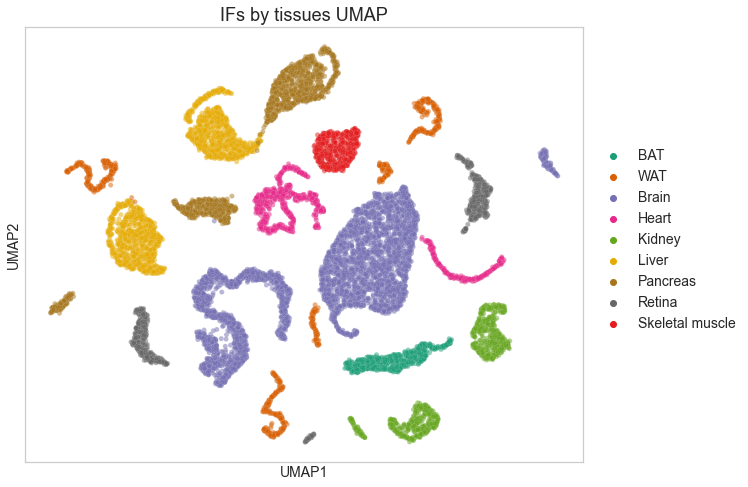

In [98]:
# UMAP for IFs colored by tissues
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(data=df, x='UMAP1', y= 'UMAP2', hue='ORGAN_2', palette=pal, 
                hue_order=['BAT', 'WAT', 'Brain', 'Heart', 'Kidney', 'Liver', 'Pancreas', 'Retina', 'Skeletal muscle'],
                s=25, linewidth=0.15, alpha = 0.5)
ax.set_ylabel('UMAP2', fontsize=14)
ax.set_xlabel('UMAP1', fontsize=14)
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_yticklabels([])
# Legend
celulas = ['BAT', 'WAT', 'Brain', 'Heart', 'Kidney', 'Liver', 'Pancreas', 'Retina', 'Skeletal muscle']
h, l = ax.get_legend_handles_labels()
legend= ax.legend(h, celulas, bbox_to_anchor=(1.005, 0.75), title="", fontsize=14)
legend.set_frame_on(False)
plt.title('IFs by tissues UMAP', size=18)

plt.savefig(outputdir+'/IF_umap_2.png',bbox_inches='tight', dpi=600)
plt.show()

In [23]:
# Clarifying Cones from Rods
for index, rows in df.iterrows():
    if df.loc[index, 'REGION'] == 'Rods':
        df.loc[index, 'CELL TYPE 2'] = 'Rods'
    
    elif df.loc[index, 'REGION'] == 'Cones':
        df.loc[index, 'CELL TYPE 2'] = 'Cones'
    
    else:
        df.loc[index, 'CELL TYPE 2'] = df.loc[index, 'CELL TYPE']

print(df.columns)
print(df['CELL TYPE 2'].unique())


Index(['ORGAN', 'ORGAN_2', 'REGION', 'AREA', 'CELL TYPE', 'SEX', 'AGE',
       'CMA ACTIVITY (Den+L1+)', '% of L1', 'L1+', 'NeuN', 'GFAP', 'Calbindin',
       'Recoverin', 'Arrestin', 'Hepato', 'Kupf', 'bat', 'vwat', 'swat',
       'Acin', 'Insulin', 'Glucagon', 'Musc', 'Glom', 'Tub', 'Aquaporin',
       'Cor', 'UMAP1', 'UMAP2', 'std_CMA_actv', 'std_%L1', 'std_L1+',
       'CELL TYPE 2'],
      dtype='object')
['Neurons' 'Astrocytes' 'Rods' 'Cones' 'Hepatocytes' 'Kupffer'
 'Adipocytes' 'Acinar cells' 'β-cells' 'α- cells' 'Myofibers'
 'Collecting ducts' 'Tubules' 'Glomeruli' 'Cardiomyocytes']


In [25]:
# Slicing df by sex
df_f = df[df.SEX == 'Female']
df_m = df[df.SEX == 'Male']

In [197]:
# Interactive figure for GitHub

# Preparing subplots
fig = make_subplots(rows=3, cols=2) #column_titles=["FEMALE", "MALE"], row_titles=["CMA activity", "% of CMA-active lysosomes", "Endolysosomes"])

# 1st and 2nd subplot, CMA activity comparison by sex
fig.add_trace(go.Scatter(x=df_f['UMAP1'], y=df_f['UMAP2'], mode='markers',
                         marker=dict(color=df_f['std_CMA_actv'], colorscale='Jet', colorbar=dict(title='', thickness=10,
                                                                                                 len=0.25, y=0.87),
                                     colorbar_x=0.45, cmin=(np.min(df.std_CMA_actv)), cmax=1, size=3.5),
                                     customdata=df_f[['ORGAN_2', 'CELL TYPE 2']],
                                     hovertemplate="<br>".join([
                                         "UMAP1: %{x}",
                                         "UMAP2: %{y}",
                                         "Organ: %{customdata[0]}",
                                         "Cell type: %{customdata[1]}"
                                         ]), showlegend= False), row=1, col=1)
fig['layout']['xaxis'].update(title_text='UMAP1', tickfont=dict(color="rgba(0,0,0,0)", size=1))
fig['layout']['yaxis'].update(title_text='UMAP2', tickfont=dict(color="rgba(0,0,0,0)", size=1))

# 2nd subplot
fig.add_trace(go.Scatter(x=df_m['UMAP1'], y=df_m['UMAP2'], mode='markers',
                         marker=dict(color=df_m['std_CMA_actv'], colorscale='Jet', colorbar=dict(title='', thickness=10,
                                                                                                 len=0.25, y=0.87),
                                     colorbar_x=1, cmin=(np.min(df.std_CMA_actv)), cmax=1, size=3.5),
                                     customdata=df_m[['ORGAN_2', 'CELL TYPE 2']],
                                     hovertemplate="<br>".join([
                                         "UMAP1: %{x}",
                                         "UMAP2: %{y}",
                                         "Organ: %{customdata[0]}",
                                         "Cell type: %{customdata[1]}"
                                         ]), showlegend= False), row=1, col=2)
fig['layout']['xaxis2'].update(title_text='UMAP1', tickfont=dict(color="rgba(0,0,0,0)", size=1))
fig['layout']['yaxis2'].update(title_text='UMAP2', tickfont=dict(color="rgba(0,0,0,0)", size=1))


# 3rd and 4th subplot, % of CMA active lysosomes, comparison by sex
fig.add_trace(go.Scatter(x=df_f['UMAP1'], y=df_f['UMAP2'], mode='markers',
                         marker=dict(color=df_f['std_%L1'], colorscale='Jet', colorbar=dict(title='', thickness=10,
                                                                                            len=0.25, y=0.5),
                                     colorbar_x=0.45, cmin=(np.min(df['std_%L1'])), cmax=2, size=3.5),
                                     customdata=df_f[['ORGAN_2', 'CELL TYPE 2']],
                                     hovertemplate="<br>".join([
                                         "UMAP1: %{x}",
                                         "UMAP2: %{y}",
                                         "Organ: %{customdata[0]}",
                                         "Cell type: %{customdata[1]}"
                                         ]), showlegend= False), row=2, col=1)
fig['layout']['xaxis3'].update(title_text='UMAP1', tickfont=dict(color="rgba(0,0,0,0)", size=1))
fig['layout']['yaxis3'].update(title_text='UMAP2', tickfont=dict(color="rgba(0,0,0,0)", size=1))

# 4th subplot
fig.add_trace(go.Scatter(x=df_m['UMAP1'], y=df_m['UMAP2'], mode='markers',
                         marker=dict(color=df_m['std_%L1'], colorscale='Jet', colorbar=dict(title='', thickness=10,
                                                                                            len=0.25, y=0.5),
                                     colorbar_x=1, cmin=(np.min(df['std_%L1'])), cmax=2, size=3.5),
                                     customdata=df_m[['ORGAN_2', 'CELL TYPE 2']],
                                     hovertemplate="<br>".join([
                                         "UMAP1: %{x}",
                                         "UMAP2: %{y}",
                                         "Organ: %{customdata[0]}",
                                         "Cell type: %{customdata[1]}"
                                         ]), showlegend= False), row=2, col=2)
fig['layout']['xaxis4'].update(title_text='UMAP1', tickfont=dict(color="rgba(0,0,0,0)", size=1))
fig['layout']['yaxis4'].update(title_text='UMAP2', tickfont=dict(color="rgba(0,0,0,0)", size=1))

# 5th and 6th subplot, Endolysosome number comparison by sex
fig.add_trace(go.Scatter(x=df_f['UMAP1'], y=df_f['UMAP2'], mode='markers',
                         marker=dict(color=df_f['std_L1+'], colorscale='Jet', colorbar=dict(title='', thickness=10,
                                                                                            len=0.25, y=0.13),
                                     colorbar_x=0.45, cmin=(np.min(df['std_L1+'])), cmax=1.5, size=3.5),
                                     customdata=df_f[['ORGAN_2', 'CELL TYPE 2']],
                                     hovertemplate="<br>".join([
                                         "UMAP1: %{x}",
                                         "UMAP2: %{y}",
                                         "Organ: %{customdata[0]}",
                                         "Cell type: %{customdata[1]}"
                                         ]), showlegend= False), row=3, col=1)
fig['layout']['xaxis5'].update(title_text='UMAP1', tickfont=dict(color="rgba(0,0,0,0)", size=1))
fig['layout']['yaxis5'].update(title_text='UMAP2', tickfont=dict(color="rgba(0,0,0,0)", size=1))

# 6th subplot
fig.add_trace(go.Scatter(x=df_m['UMAP1'], y=df_m['UMAP2'], mode='markers',
                         marker=dict(color=df_m['std_L1+'], colorscale='Jet', colorbar=dict(title='', thickness=10,
                                                                                            len=0.25, y=0.13),
                                     colorbar_x=1, cmin=(np.min(df['std_L1+'])), cmax=1.5, size=3.5),
                                     customdata=df_m[['ORGAN_2', 'CELL TYPE 2']],
                                     hovertemplate="<br>".join([
                                         "UMAP1: %{x}",
                                         "UMAP2: %{y}",
                                         "Organ: %{customdata[0]}",
                                         "Cell type: %{customdata[1]}"
                                         ]), showlegend= False), row=3, col=2)
fig['layout']['xaxis6'].update(title_text='UMAP1', tickfont=dict(color="rgba(0,0,0,0)", size=1))
fig['layout']['yaxis6'].update(title_text='UMAP2', tickfont=dict(color="rgba(0,0,0,0)", size=1))


# Column titles
fig.add_annotation(text="FEMALE", x=0.19, y=1.045, xref="paper", yref="paper", showarrow=False, font=dict(size=20))
fig.add_annotation(text="MALE", x=0.8, y=1.045, xref="paper", yref="paper", showarrow=False, font=dict(size=20))

# Row titles
fig.add_annotation(text="CMA Activity", x=-0.07, y=0.95, textangle=-90, xref="paper", yref="paper", showarrow=False, font=dict(size=20))
fig.add_annotation(text="% of CMA-active lysosomes", x=-0.07, y=0.50, textangle=-90, xref="paper", yref="paper", showarrow=False, font=dict(size=20))
fig.add_annotation(text="Endolysosomes", x=-0.07, y=0.04, textangle=-90, xref="paper", yref="paper", showarrow=False, font=dict(size=20))

# Title for all subplots
fig.update_layout(height=1000, width=1250, showlegend=False,
                  title=dict(text="<b>CMA activity parameters</b>", font=dict(size=35)))

# Saving html
fig.write_html(output_dir + "/CMA_param.html")
fig.show()

In [39]:
# Interactive UMAP for IFs
fig_2d = px.scatter(
        df, x="UMAP1", y="UMAP2", color='ORGAN_2', symbol= df['CELL TYPE 2'],
        color_discrete_sequence=pal2)

fig_2d.update_layout(legend_title_text="Tissue & Cell type")

# Customizing the symbol size
fig_2d.update_traces(marker=dict(size=6),
                  selector=dict(mode='markers'))
#fig_2d.update_traces(marker=dict(color=pal2))

fig_2d.show()
fig_2d.write_html(outputdir+'/IF_umap_interactive.html')

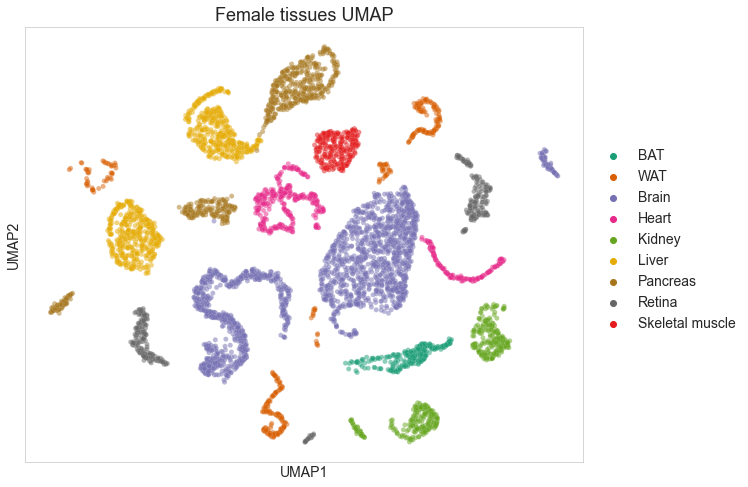

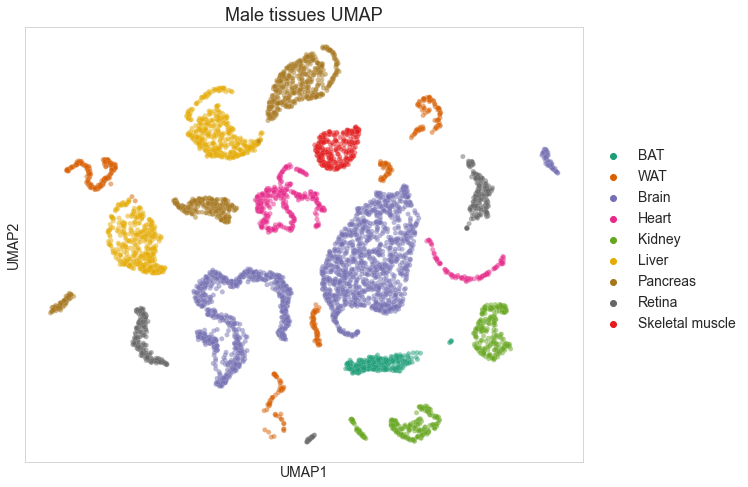

In [12]:
# UMAPs for IFs per gender colored by tissues
for i in df.SEX.unique():    
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=df[df['SEX']==i], x='UMAP1', y= 'UMAP2', 
                    hue='ORGAN_2', palette=pal, 
                    hue_order=['BAT', 'WAT', 'Brain', 'Heart', 'Kidney', 'Liver', 
                               'Pancreas', 'Retina', 'Skeletal muscle'],
                    s=25, linewidth=0.15, alpha = 0.5)
    ax.set_ylabel('UMAP2', fontsize=14)
    ax.set_xlabel('UMAP1', fontsize=14)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    # Legend
    celulas = ['BAT', 'WAT', 'Brain', 'Heart', 'Kidney', 'Liver', 'Pancreas', 'Retina', 'Skeletal muscle']
    h, l = ax.get_legend_handles_labels()
    legend= ax.legend(h, celulas, bbox_to_anchor=(1.005, 0.75), title="", fontsize=14)
    legend.set_frame_on(False)
    plt.title('{} tissues UMAP'.format(i), size=18)

    if i == 'Female':
        plt.savefig(outputdir+'/IF_umap_f2.png',bbox_inches='tight', dpi=600)
    else:
        plt.savefig(outputdir+'/IF_umap_m2.png',bbox_inches='tight', dpi=600)

    plt.show()

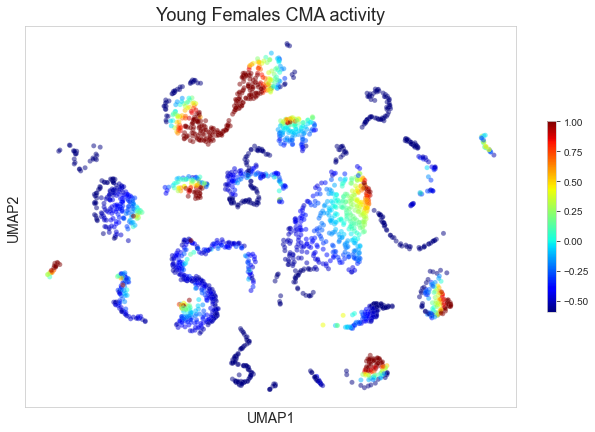

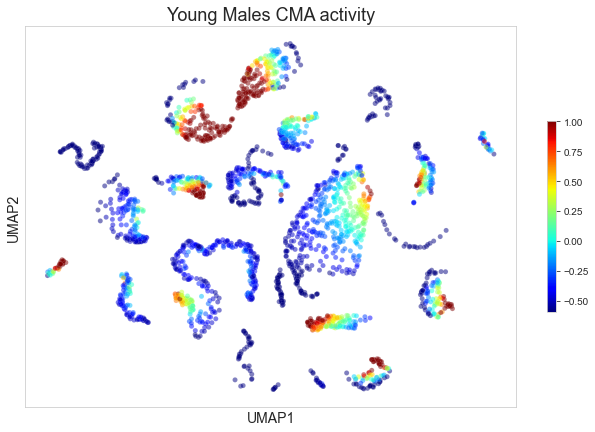

In [10]:
# UMAPs for IFs CMA activity per gender & age
sns.set_style("whitegrid")
for i in df.SEX.unique():    
    fig, ax = plt.subplots(figsize=(11,7))
    scatter= sns.scatterplot(data=df[(df['SEX']==i)&(df['AGE']=='Young')], 
                                x='UMAP1', y= 'UMAP2', 
                                c=df[(df['SEX']==i)&(df['AGE']=='Young')]['std_CMA_actv'], 
                                cmap='jet', s=25, linewidth=0.15, 
                                alpha = 0.5, vmin=np.min(df.std_CMA_actv), vmax=1) 
    norm = plt.Normalize(np.min(df.std_CMA_actv), 1)
    sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
    sm.set_array([])
    ax.figure.colorbar(sm, shrink=.5, ticks=[-0.50, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
    ax.set_ylabel('UMAP2', fontsize=14)
    ax.set_xlabel('UMAP1', fontsize=14)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.title('Young {}s CMA activity'.format(i), size=18)    

    if i == 'Female':
        plt.savefig(outputdir+'/IF_umap_'+'fycma.png',bbox_inches='tight', 
                    dpi=600)
    elif i == 'Male':
        plt.savefig(outputdir+'/IF_umap_'+'mycma.png',bbox_inches='tight', 
                    dpi=600)

    plt.show()

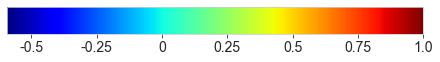

In [16]:
# Colorbars independent. First for CMA activity
fig, ax = plt.subplots(figsize=(6, 0.75), layout='constrained')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(np.min(df.std_CMA_actv), vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')

ax.set_xticks([-0.50, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels(labels=[-0.50, -0.25, 0, 0.25, 0.5, 0.75, 1.0], size=14)
plt.savefig(outputdir+'/cbar_cmaact.png',bbox_inches='tight', dpi=600)
plt.show()

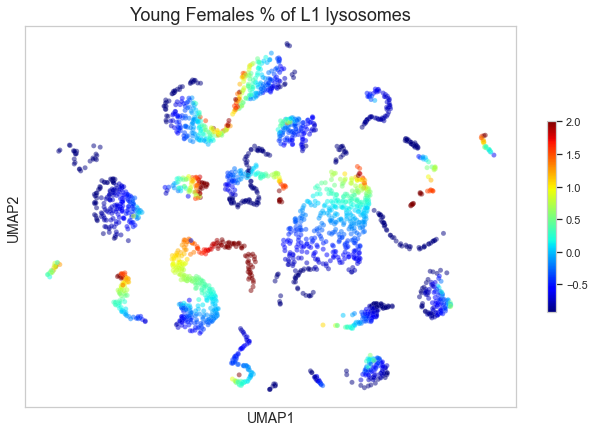

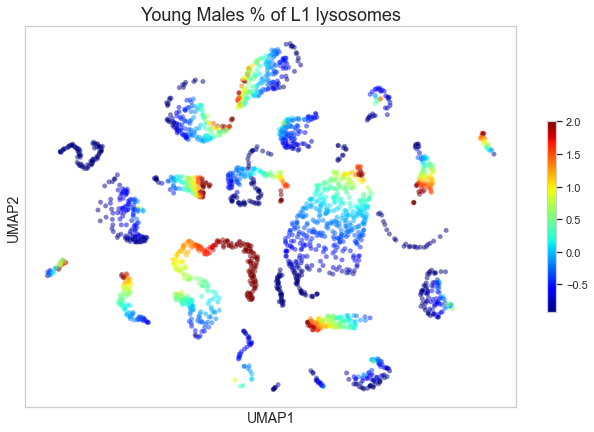

In [111]:
#UMAPs for IFs % of L1 per gender & age
for i in df.SEX.unique():
        fig, ax = plt.subplots(figsize=(11,7))
        scatter= sns.scatterplot(data=df[(df['SEX']==i)&(df['AGE']=='Young')], 
                                 x='UMAP1', y= 'UMAP2', 
                                 c=df[(df['SEX']==i)&(df['AGE']=='Young')]['std_%L1'], 
                                 cmap='jet', s=25, linewidth=0.15, 
                                 alpha = 0.5, vmin=np.min(df['std_%L1']), vmax= 2) 
        norm = plt.Normalize(np.min(df['std_%L1']), 2)
        sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
        sm.set_array([])
        ax.figure.colorbar(sm, shrink=.5)
        ax.set_ylabel('UMAP2', fontsize=14)
        ax.set_xlabel('UMAP1', fontsize=14)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_yticklabels([])
        plt.title('Young {}s % of L1 lysosomes'.format(i), size=18)    
        if i == 'Female':
            plt.savefig(outputdir+'/IF_umap_'+'fyl1per.png',bbox_inches='tight', 
                        dpi=600)
        elif i == 'Male':
            plt.savefig(outputdir+'/IF_umap_'+'myl1per.png',bbox_inches='tight', 
                        dpi=600)
        
        plt.show()
    

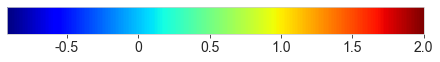

In [17]:
# Colorbars independent. Second for %L1
fig, ax = plt.subplots(figsize=(6, .75), layout='constrained')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=np.min(df['std_%L1']), vmax=2)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')

ax.set_xticks([-0.50, 0, 0.5, 1.0, 1.5, 2.0])
ax.set_xticklabels(labels=[-0.50, 0, 0.5, 1.0, 1.5, 2.0], size=14)
plt.savefig(outputdir+'/cbar_l1per.png',bbox_inches='tight', dpi=600)
plt.show()

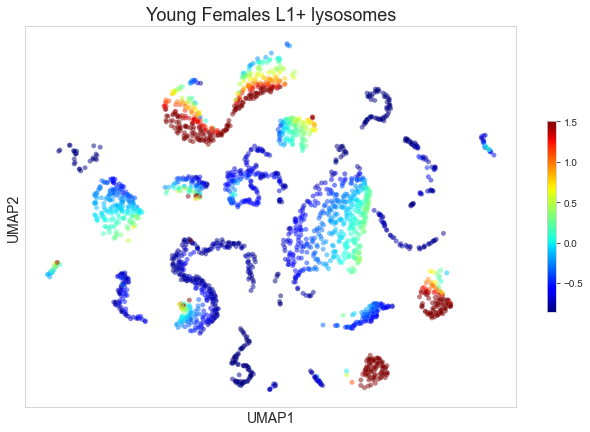

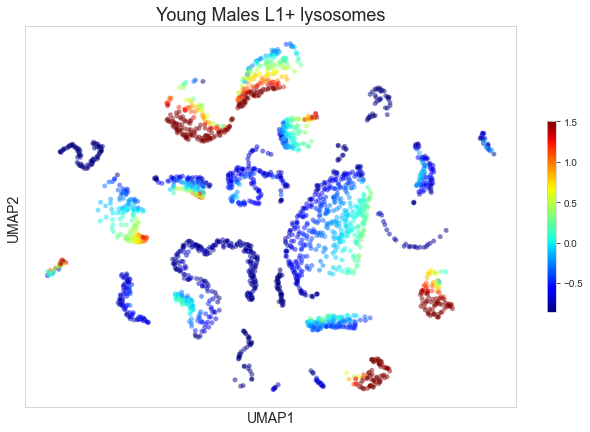

In [13]:
#UMAPs for IFs L1 positive per gender & age
for i in df.SEX.unique():    
    fig, ax = plt.subplots(figsize=(11,7))
    scatter= sns.scatterplot(data=df[(df['SEX']==i)&(df['AGE']=='Young')], 
                                x='UMAP1', y= 'UMAP2', 
                                c=df[(df['SEX']==i)&(df['AGE']=='Young')]['std_L1+'], 
                                cmap='jet', s=25, linewidth=0.15, 
                                alpha = 0.5, vmin=np.min(df['std_L1+']), vmax=1.5) 
    norm = plt.Normalize(np.min(df['std_L1+']), 1.5)
    sm = plt.cm.ScalarMappable(cmap="jet", norm=norm)
    sm.set_array([])
    ax.figure.colorbar(sm, shrink=.5)
    ax.set_ylabel('UMAP2', fontsize=14)
    ax.set_xlabel('UMAP1', fontsize=14)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    plt.title('Young {}s L1+ lysosomes'.format(i), size=18)    

    if i == 'Female':
        plt.savefig(outputdir+'/IF_umap_'+'fyl1pos.png',bbox_inches='tight', 
                    dpi=600)
    
    else:
        plt.savefig(outputdir+'/IF_umap_'+'myl1pos.png',bbox_inches='tight', 
                    dpi=600)
    
    plt.show()

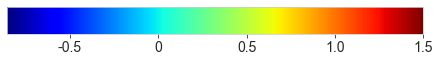

In [18]:
# Colorbars independent. Third for L1 positive
fig, ax = plt.subplots(figsize=(6, .75), layout='constrained')

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=np.min(df['std_L1+']), vmax=1.5)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal')

ax.set_xticks([-0.50, 0, 0.5, 1.0, 1.5])
ax.set_xticklabels(labels=[-0.50, 0, 0.5, 1.0, 1.5], size=14)
plt.savefig(outputdir+'/cbar_l1pos.png',bbox_inches='tight', dpi=600)
plt.show()

## 3. Summary plots all cell types and all lysosomal parameters

In [3]:
# Loading data
df = pd.read_excel('./CMA_aging_Atlas_sumdata.xlsx')

#Correcting some misspelled errors
df['Cell_type'] = df['Cell_type'].replace('EC Astrocytes', 'EC astrocytes')
df['Cell_type'] = df['Cell_type'].replace('SC Astrocytes', 'SC astrocytes')
df['Cell_type'] = df['Cell_type'].replace('Cone photoreceptors', 'Cones photoreceptors')

print(df.Cell_type.unique())

df.head()

['Acinar Cells' 'BAT' 'CA1 astrocytes' 'CA1 neurons'
 'CB excitatory neurons' 'CB inhibitory neurons' 'Cardiomyocytes'
 'Collecting Ducts' 'Cones photoreceptors' 'DG astrocytes' 'DG neurons'
 'EC astrocytes' 'EC neurons' 'Glomeruli' 'Hepatocytes' 'Kupffer Cells'
 'Rods photoreceptors' 'SC astrocytes' 'SC neurons' 'Skeletal Myofibers'
 'Tubules' 'sWAT' 'vWAT' 'α-Cells' 'β-Cells']


Cell_type    Gender_Age  CMA activity  CMA score  Fraction CMA Lys  \
0  Acinar Cells    Female Old       -0.6092    -1.0381           -0.8959   
1  Acinar Cells  Female Young        0.4535     0.2207            1.1509   
2  Acinar Cells      Male Old       -1.0201    -0.4687           -0.7757   
3  Acinar Cells    Male Young        1.1758     1.2861            0.5207   
4           BAT    Female Old       -0.3114    -0.1572           -0.5606   

   L1 number  
0     0.1566  
1    -0.0115  
2    -1.2901  
3     1.1450  
4     0.0520

In [4]:
# Cell types
celulas = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons',  
           'Rods photoreceptors', 'Cones photoreceptors', 'Hepatocytes', 
           'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Glomeruli', 'Tubules', 
           'Collecting Ducts', 'Cardiomyocytes']

#Cell names without retina cells because they are not in Tabula muris
celulas2 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons',  
           'Hepatocytes', 'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Glomeruli', 'Tubules', 
           'Collecting Ducts', 'Cardiomyocytes']

#Brain cells' names
brain = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
         'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
         'CB inhibitory neurons', 'CB excitatory neurons',  
         'Rods photoreceptors', 'Cones photoreceptors']

#Brain cells' names no retina
brain2 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
          'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
          'CB inhibitory neurons', 'CB excitatory neurons']

#Metabolic cells' names
metab = ['Hepatocytes', 'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
         'α-Cells', 'Skeletal Myofibers']

In [5]:
#Cell names without lung and heart
celulas3 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons',  
           'Rods photoreceptors', 'Cones photoreceptors', 'Hepatocytes', 
           'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Glomeruli', 'Tubules', 
           'Collecting Ducts']

celulas4 = ['CA1 neurons', 'DG neurons', 'SC neurons', 'EC neurons',
           'CA1 astrocytes', 'DG astrocytes', 'SC astrocytes', 'EC astrocytes', 
           'CB inhibitory neurons', 'CB excitatory neurons',  
           'Hepatocytes', 'Kupffer Cells', 'BAT', 'vWAT', 'sWAT', 'Acinar Cells', 'β-Cells',
           'α-Cells', 'Skeletal Myofibers', 'Glomeruli', 'Tubules', 
           'Collecting Ducts']

In [6]:
# Df with no retina cells
df2 = df.loc[df['Cell_type'].isin(celulas2), :]
df2.shape

(92, 6)

In [7]:
#Setting Gender & age cathegories
df['Gender_Age']=pd.Categorical(values=df.Gender_Age, categories=['Female Young', 'Female Old', 'Male Young', 'Male Old'], ordered=True)
df2['Gender_Age']=pd.Categorical(values=df2.Gender_Age, categories=['Female Young', 'Female Old', 'Male Young', 'Male Old'], ordered=True)

In [8]:
#Setting cell type cathegories
df['Cell_type']=pd.Categorical(values=df.Cell_type, categories=celulas, ordered=True)
df2['Cell_type']=pd.Categorical(values=df2.Cell_type, categories=celulas2, ordered=True)

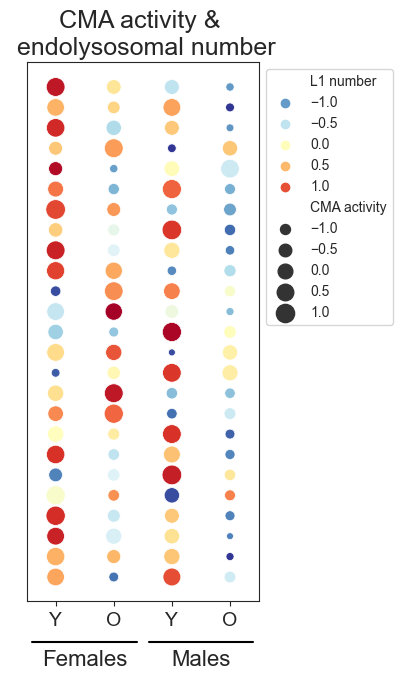

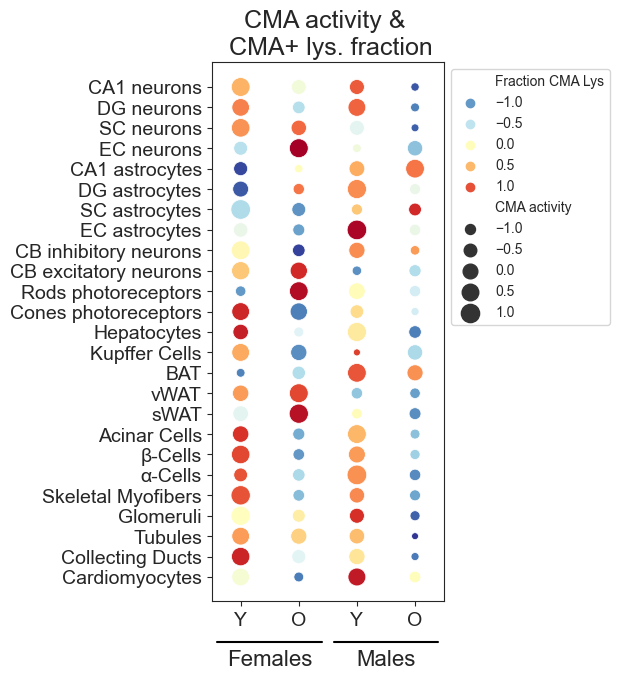

In [32]:
sns.set_style("ticks")
#Summary graphs combining parameters
for i in ['L1 number', 'Fraction CMA Lys']:
    fig, ax = plt.subplots(figsize=(3,7))
    sns.scatterplot(data=df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                    hue=i, palette='RdYlBu_r', sizes=(25, 200))
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('')
    plt.ylabel('')
    plt.xlim(-0.5, 3.5)
    ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)

    if i == 'L1 number':
        ax.set_yticklabels([])
        ax.set_yticks([])
    else:
        ax.set_yticklabels(celulas, size= 14)
        

    # Female & male
    trans = ax.get_xaxis_transform()
    ax.annotate('Females', xy=(0.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
    ax.plot([-.4,1.4],[-.075,-.075], color="k", transform=trans, clip_on=False)
    ax.annotate('Males', xy=(2.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
    ax.plot([1.6,3.4],[-.075,-.075], color="k", transform=trans, clip_on=False)

    # Titles and saving
    if i == 'L1 number':
        plt.title('CMA activity & \n endolysosomal number', size=18)        
        plt.savefig(outputdir+'/Sum_cmal1pos.png',bbox_inches='tight', dpi=600)
    else:
        plt.title('CMA activity & \n CMA+ lys. fraction', size=18)
        plt.savefig(outputdir+'/Sum_cmal1per.png',bbox_inches='tight', dpi=600)
    plt.show()

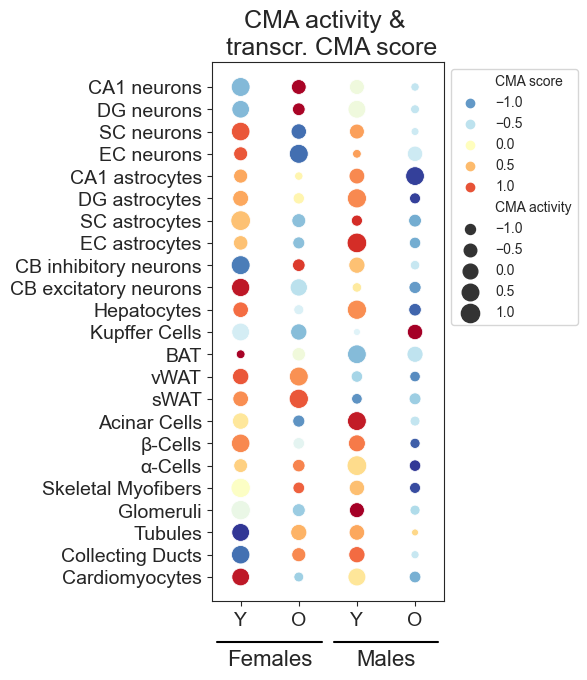

In [33]:
#Summary graph for CMA activity and score, separated because we don´t have CMA score for retina cells
fig, ax = plt.subplots(figsize=(3,7))
sns.scatterplot(data=df2, x='Gender_Age', y='Cell_type', size='CMA activity', 
                hue='CMA score', palette='RdYlBu_r', sizes=(25, 200))
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('')
plt.xlim(-0.5, 3.5)
ax.set_yticklabels(celulas2, size= 14)
ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Females', xy=(0.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([-.4,1.4],[-.075,-.075], color="k", transform=trans, clip_on=False)
ax.annotate('Males', xy=(2.5, -0.09), xycoords=trans, ha="center", va="top", size=16)
ax.plot([1.6,3.4],[-.075,-.075], color="k", transform=trans, clip_on=False)

# Titles and saving
plt.title('CMA activity & \n transcr. CMA score', size=18)
plt.savefig(outputdir+'/Sum_actsco.png',bbox_inches='tight', dpi=600)
plt.show()

## Creating subsets for graphs of CNS and Metabolic tissues alone

In [11]:
# Slicing df
brain_df = df[df['Cell_type'].isin(brain)]
brain_df2 = df[df['Cell_type'].isin(brain2)]
metab_df = df[df['Cell_type'].isin(metab)]


# Setting cell type cathegories
brain_df['Cell_type']=pd.Categorical(values=brain_df.Cell_type, categories=brain, ordered=True)
brain_df2['Cell_type']=pd.Categorical(values=brain_df2.Cell_type, categories=brain2, ordered=True)
metab_df['Cell_type']=pd.Categorical(values=metab_df.Cell_type, categories=metab, ordered=True)


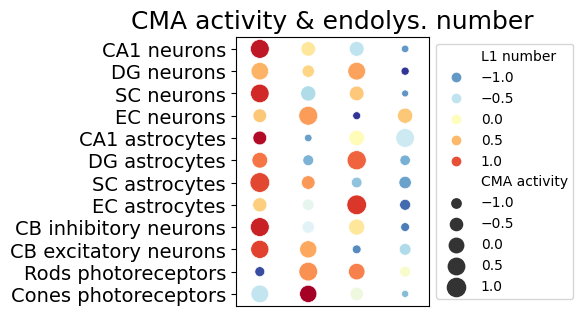

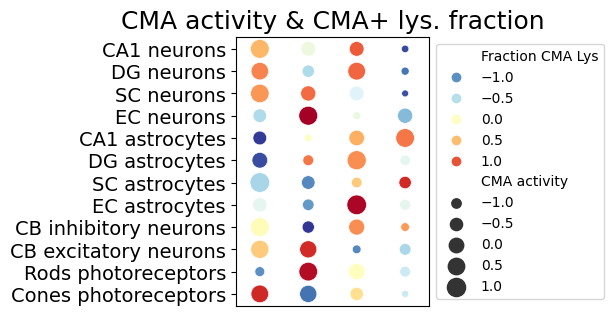

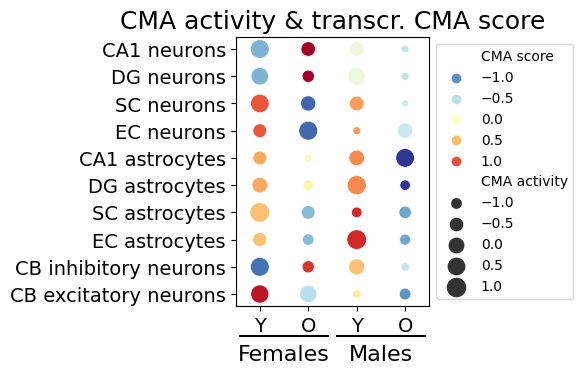

In [13]:
# Summary graphs for CNS only
for i in ['L1 number', 'Fraction CMA Lys', 'CMA score']:
    if i is not 'CMA score':
        fig, ax = plt.subplots(figsize=(2.5,3.5))
        sns.scatterplot(data=brain_df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels(brain, size= 14)

        if i == 'L1 number':
            plt.title('CMA activity & endolys. number', size=18)        
            plt.savefig(outputdir+'/Sum_cmal1pos_cns.png',bbox_inches='tight', dpi=600)
        else:
            plt.title('CMA activity & CMA+ lys. fraction', size=18)
            plt.savefig(outputdir+'/Sum_cmal1per_cns.png',bbox_inches='tight', dpi=600)

    else:
        fig, ax = plt.subplots(figsize=(2.5, 3.5))
        sns.scatterplot(data=brain_df2, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
        ax.set_yticklabels(brain2, size= 14)
        
        # Female & male
        trans = ax.get_xaxis_transform()
        ax.annotate('Females', xy=(0.5, -0.14), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([-.4,1.4],[-.11,-.11], color="k", transform=trans, clip_on=False)
        ax.annotate('Males', xy=(2.5, -0.14), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([1.6,3.4],[-.11,-.11], color="k", transform=trans, clip_on=False)

        plt.title('CMA activity & transcr. CMA score', size=18)
        plt.savefig(outputdir+'/Sum_actsco_cns.png',bbox_inches='tight', dpi=600)
   
    plt.show()

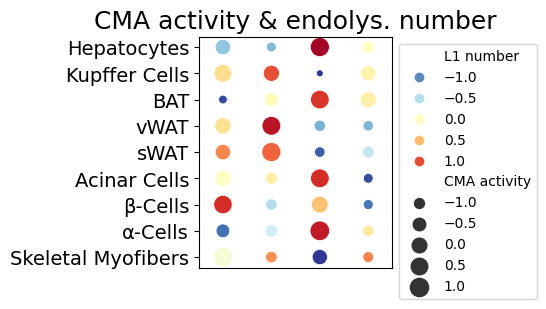

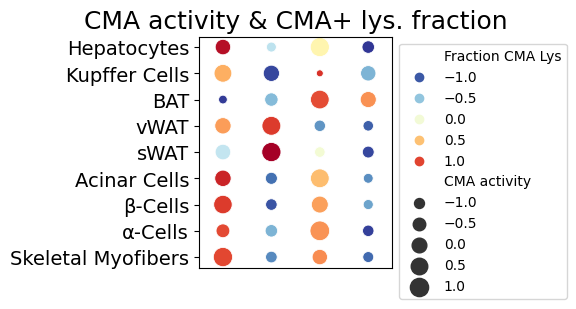

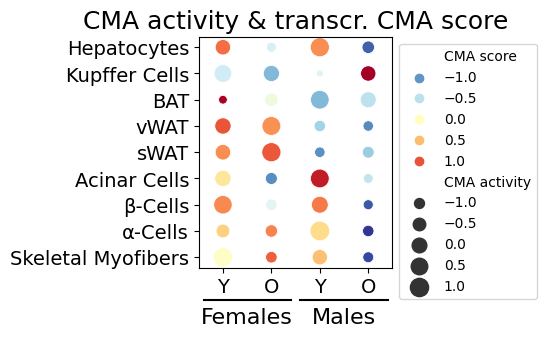

In [14]:
# Summary graphs for Mteabolic tissues only
for i in ['L1 number', 'Fraction CMA Lys', 'CMA score']:
    if i is not 'CMA score':
        fig, ax = plt.subplots(figsize=(2.5,3))
        sns.scatterplot(data=metab_df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticklabels(metab, size= 14)

        if i == 'L1 number':
            plt.title('CMA activity & endolys. number', size=18)        
            plt.savefig(outputdir+'/Sum_cmal1pos_metab.png',bbox_inches='tight', dpi=600)
        else:
            plt.title('CMA activity & CMA+ lys. fraction', size=18)
            plt.savefig(outputdir+'/Sum_cmal1per_metab.png',bbox_inches='tight', dpi=600)

    else:
        fig, ax = plt.subplots(figsize=(2.5, 3))
        sns.scatterplot(data=metab_df, x='Gender_Age', y='Cell_type', size='CMA activity', 
                        hue=i, palette='RdYlBu_r', sizes=(25, 200))
        plt.legend(bbox_to_anchor=(1, 1))
        plt.xlabel('')
        plt.ylabel('')
        plt.xlim(-0.5, 3.5)
        ax.set_xticklabels(['Y', 'O', 'Y', 'O'], size= 14)
        ax.set_yticklabels(metab, size= 14)
        
        # Female & male
        trans = ax.get_xaxis_transform()
        ax.annotate('Females', xy=(0.5, -0.17), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([-.4,1.4],[-.14,-.14], color="k", transform=trans, clip_on=False)
        ax.annotate('Males', xy=(2.5, -0.17), xycoords=trans, ha="center", va="top", size=16)
        ax.plot([1.6,3.4],[-.14,-.14], color="k", transform=trans, clip_on=False)

        plt.title('CMA activity & transcr. CMA score', size=18)
        plt.savefig(outputdir+'/Sum_actsco_metab.png',bbox_inches='tight', dpi=600)
   
    plt.show()